<a href="https://colab.research.google.com/github/Urz1/AI-Powered-Air-Quality-Prediction/blob/main/AI_Powered_Air_Quality_Prediction_Tool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#                  **Overview**

The "AI Air Quality Guardian" is a Python-based project designed to predict daily air quality ("Safe" or "Alert") using historical data and real-time updates via the OpenWeatherMap API. It aims to empower urban residents with actionable air quality insights, focusing on NOx levels, temperature, and humidity. This manual walks through each code block, detailing its purpose, functionality, and expected outcomes.

# Import Libraries and Load Data
**Purpose**

- To import necessary Python libraries and load the historical air quality dataset into memory, preparing it for preprocessing.

**Functionality**

- Imports:
  - pandas: For data manipulation and analysis.
  - matplotlib.pyplot: For creating visualizations.
  - requests: To fetch real-time data from the OpenWeatherMap API.
  - sklearn.model_selection and sklearn.linear_model: For model training and validation.
- Data Loading:
  - Reads the AirQuality.csv file from the specified path (/content/sample_data/AirQuality.csv) using pd.read_csv, handling missing values (-200, NA, "") as NaN.
  - Drops unnecessary columns (Unnamed: 15, Unnamed: 16) that contain no useful data.

- **Preprocessing**:
  - Converts comma-separated numeric strings (e.g., 2,6) to float values (e.g., 2.6) for all specified columns.
  - Removes rows with missing values in key columns (NOx(GT), T, RH, AH).
- **Output**:
  - Prints the head of the cleaned dataset, its shape (rows, columns), and data types to verify the preprocessing.
- **Aims**
  - Ensure the dataset is clean and ready for analysis by handling missing data and converting formats.
  - Provide a checkpoint to confirm the data structure before aggregation.

**Expected Output**
  - Cleaned Data Head: First 5 rows of the dataset.
  - Data Shape: e.g., (7396, 15) (rows, columns after dropping unused ones).
  - Data Types: All numeric columns as float64, others as object.

**Troubleshooting**
- Error: FileNotFoundError - Check the file path; ensure AirQuality.csv is in /content/sample_data/.
- ValueError during Conversion - Verify all values in numeric_columns are convertible to floats; adjust the list if needed.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load the dataset with error handling
try:
    data = pd.read_csv("/content/sample_data/AirQuality.csv", sep=";", na_values=["-200", "NA", ""])
    data = data.drop(columns=["Unnamed: 15", "Unnamed: 16"])
except FileNotFoundError:
    print("Error: AirQuality.csv file not found. Please check the file path.")
    raise

# Replace commas with dots in numeric columns and convert to float
numeric_columns = ["CO(GT)", "PT08.S1(CO)", "NMHC(GT)", "C6H6(GT)", "PT08.S2(NMHC)",
                   "NOx(GT)", "PT08.S3(NOx)", "NO2(GT)", "PT08.S4(NO2)", "PT08.S5(O3)",
                   "T", "RH", "AH"]
for col in numeric_columns:
    data[col] = data[col].astype(str).str.replace(",", ".").astype(float)

# Handle outliers: Cap extreme values using IQR method
for col in ["NOx(GT)", "CO(GT)", "C6H6(GT)", "T", "RH"]:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data[col] = data[col].clip(lower_bound, upper_bound)

# Drop rows with missing values in key columns
data = data.dropna(subset=["NOx(GT)", "T", "RH", "CO(GT)", "C6H6(GT)"])

# Check the data
print("Cleaned Data Head:")
print(data.head())
print("Data Shape:", data.shape)
print("Data Types:", data.dtypes)

Cleaned Data Head:
         Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
0  10/03/2004  18.00.00     2.6       1360.0     150.0      11.9   
1  10/03/2004  19.00.00     2.0       1292.0     112.0       9.4   
2  10/03/2004  20.00.00     2.2       1402.0      88.0       9.0   
3  10/03/2004  21.00.00     2.2       1376.0      80.0       9.2   
4  10/03/2004  22.00.00     1.6       1272.0      51.0       6.5   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0         1046.0    166.0        1056.0    113.0        1692.0       1268.0   
1          955.0    103.0        1174.0     92.0        1559.0        972.0   
2          939.0    131.0        1140.0    114.0        1555.0       1074.0   
3          948.0    172.0        1092.0    122.0        1584.0       1203.0   
4          836.0    131.0        1205.0    116.0        1490.0       1110.0   

      T    RH      AH  
0  13.6  48.9  0.7578  
1  13.3  47.7  0.7255  
2  11.9  54.0  0.7502  
3

# **Aggregate Data and Create Target**
**Purpose**

- To aggregate the hourly data into daily averages and create a target variable for air quality prediction.

**Functionality**

- Aggregation:
    - Combines Date and Time into a DateTime object using pd.to_datetime.
    - Groups data by date and calculates the mean for all numeric columns, resetting the index to include the date.

**Target Creation:**

- Defines AirQuality as "Safe" if NOx(GT) < 200 µg/m³, otherwise "Alert".

**Output:**

- Prints the head of the daily aggregated dataset and its shape.

**Aims**
- Simplify the dataset by reducing noise from hourly data, focusing on daily trends.
- Establish a binary classification target based on the NOx threshold for model training.

**Expected Output**
- Daily Data Head: First 5 rows with daily averages, including the AirQuality column.
- Daily Data Shape: e.g., (~400-500, 14) (depending on unique dates).

**Troubleshooting**

- TypeError during Aggregation - Ensure all numeric columns are converted to floats in Block 1.
- ValueError in DateTime - Check Date and Time formats match `%d/%m/%Y %H.%M.%S`.

In [ ]:
# Aggregate to daily averages for numeric columns only
data["DateTime"] = pd.to_datetime(data["Date"] + " " + data["Time"], format="%d/%m/%Y %H.%M.%S")
daily_data = data.groupby(data["DateTime"].dt.date)[numeric_columns].mean().reset_index()
daily_data.rename(columns={"DateTime": "Date"}, inplace=True)

# Create feature interaction term (NOx × Temperature)
daily_data["NOx_T_Interaction"] = daily_data["NOx(GT)"] * daily_data["T"]

# Create target column: "Safe" (NOx(GT) < 200) or "Alert" (NOx(GT) >= 200)
daily_data["AirQuality"] = daily_data["NOx(GT)"].apply(lambda x: "Safe" if x < 200 else "Alert")

# Check the aggregated data
print("Daily Data Head:")
print(daily_data.head())
print("Daily Data Shape:", daily_data.shape)

Daily Data Head:
         Date    CO(GT)  PT08.S1(CO)    NMHC(GT)   C6H6(GT)  PT08.S2(NMHC)  \
0  2004-03-10  1.966667  1316.500000   86.500000   8.450000     912.333333   
1  2004-03-11  2.245455  1265.409091  112.500000   8.568182     879.954545   
2  2004-03-12  2.859524  1309.285714  169.761905  12.447619    1036.476190   
3  2004-03-13  2.740909  1346.227273  147.272727  11.381818    1010.181818   
4  2004-03-14  2.465909  1372.409091  119.045455   9.836364     950.590909   

      NOx(GT)  PT08.S3(NOx)     NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)          T  \
0  132.000000   1167.333333  108.833333   1545.500000  1096.000000  12.033333   
1  150.000000   1233.227273  102.863636   1550.727273   922.727273   9.804545   
2  181.000000   1052.619048  120.285714   1651.238095  1121.000000  11.838095   
3  187.863636    978.454545  120.500000   1613.954545  1268.818182  13.363636   
4  150.090909    999.090909  111.681818   1608.409091  1240.545455  16.390909   

          RH        AH  NOx

# Integrate OpenWeatherMap API
**Purpose**
- To fetch real-time air quality and weather data for Addis Ababa using the - OpenWeatherMap API.
**Functionality**

- API Request:
Sends a request to get weather data for Addis Ababa, extracts latitude and longitude.
Uses these coordinates to fetch air pollution data (NOx as NO2).
Converts temperature from Kelvin to Celsius.
- Error Handling:
Uses try-except to catch issues (e.g., invalid API key, city not found).
Provides fallback values (NOx=2.27 µg/m³, Temp=16.5°C, RH=61%) if the API fails.
- Output:
Prints the current data or an error message with fallback data.

**Aims**
- Integrate real-time data to enhance the model’s applicability.
- Ensure robustness against API failures for a seamless user experience.

**Expected Output**
- Current Addis Ababa Data - NOx (NO2): 2.27 µg/m³, Temp: 16.5°C, Humidity: 61% (or similar based on live data).
- Error fetching API data: ... with fallback values if the API fails.

**Troubleshooting**
- KeyError - Verify the API key and city name; ensure the key is active (may take 10-30 minutes after signup).
- ConnectionError - Check your internet connection or OpenWeatherMap server status.

In [ ]:
# Get real-time data via OpenWeatherMap API for Addis Ababa with error handling
try:
    api_key = ""  # Replace with your OpenWeatherMap API key
    city = "Addis Ababa"
    weather_url = f"http://api.openweathermap.org/data/2.5/weather?q={city}&appid={api_key}"
    weather_response = requests.get(weather_url).json()

    if "coord" not in weather_response:
        raise KeyError(f"Coordinate data not found in weather response: {weather_response}")

    lat = weather_response["coord"]["lat"]
    lon = weather_response["coord"]["lon"]
    url = f"http://api.openweathermap.org/data/2.5/air_pollution?lat={lat}&lon={lon}&appid={api_key}"
    response = requests.get(url).json()

    if "list" not in response or len(response["list"]) == 0:
        raise KeyError(f"Air pollution data not found in response: {response}")

    current_no2 = response["list"][0]["components"]["no2"]
    current_co = response["list"][0]["components"]["co"]
    current_temp = weather_response["main"]["temp"] - 273.15
    current_humidity = weather_response["main"]["humidity"]
    print(f"Current {city} Data - NOx (NO2): {current_no2} µg/m³, CO: {current_co} µg/m³, Temp: {current_temp:.1f}°C, Humidity: {current_humidity}%")
except Exception as e:
    print(f"Error fetching API data: {e}")
    # Fallback values in case of API failure
    current_no2, current_co, current_temp, current_humidity = 2.27, 363.83, 16.5, 61  # From last run
    print(f"Using fallback data for Addis Ababa: NOx=2.27 µg/m³, CO=363.83 µg/m³, Temp=16.5°C, RH=61%")

Current Addis Ababa Data - NOx (NO2): 5.1 µg/m³, CO: 1161.58 µg/m³, Temp: 18.5°C, Humidity: 26%


# Train the Model and Cross-Validate
**Purpose**
- To train a Logistic Regression model and validate its performance using cross-validation.

**Functionality**
  - Model Training:
    - Splits data into training (80%) and test (20%) sets.
    - Trains a Logistic Regression model with max_iter=1000 to ensure convergence.

- Cross-Validation:
  - Performs 5-fold cross-validation to assess model reliability.
- Output:
  - Prints the test set accuracy and cross-validation scores.

**Aims**
  - Develop a predictive model to classify air quality.
  - Validate the model’s generalization to avoid overfitting.

**Expected Output**
- Model Accuracy: 0.99 (initial test set accuracy).
- Cross-Validation Scores: [0.95 0.96 0.94 0.97 0.95].
- Average CV Accuracy: 0.95 ± 0.01 (more realistic than test accuracy alone).

**Troubleshooting**
- ConvergenceWarning - Increase max_iter if needed.
- High Accuracy - Check for data imbalance; consider adding more features if time allows.

In [ ]:
# Scale features
scaler = StandardScaler()
X = daily_data[["NOx(GT)", "T", "RH", "CO(GT)", "C6H6(GT)", "NOx_T_Interaction"]]
X_scaled = scaler.fit_transform(X)
y = daily_data["AirQuality"]

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Train Logistic Regression with stronger regularization
model = LogisticRegression(max_iter=1000, penalty='l2', C=0.01)  # Stronger regularization
model.fit(X_train, y_train)
accuracy = model.score(X_test, y_test)
print(f"Model Accuracy: {accuracy:.2f}")

# Perform stratified 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_scaled, y, cv=cv)
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Average CV Accuracy: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")

# Additional evaluation metrics
y_pred = model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Model Accuracy: 0.88
Cross-Validation Scores: [0.95652174 0.98529412 0.88235294 0.86764706 0.92647059]
Average CV Accuracy: 0.92 ± 0.04
Classification Report:
              precision    recall  f1-score   support

       Alert       1.00      0.76      0.87        34
        Safe       0.81      1.00      0.90        35

    accuracy                           0.88        69
   macro avg       0.91      0.88      0.88        69
weighted avg       0.91      0.88      0.88        69



# Make Predictions
**Purpose**
- To use the trained model to predict air quality for real-time and sample data.

**Functionality**
  - Predictions:
    - Predicts using current API data, a historical sample (NOx=150 µg/m³), and two test samples (NOx=100, 250 µg/m³).
    
- Output:
Prints predictions for each case ("Safe" or "Alert").

**Aims**
- Demonstrate the model’s practical application with live and hypothetical data.
- Validate predictions against the NOx threshold (<200 or >=200).

**Expected Output**
  - Prediction for Current Addis Ababa Data: Safe.
  - Prediction for NOx=150 µg/m³, Temp=20°C, RH=50%: Safe.
  - Sample 1: NOx=100, Temp=15, RH=40 -> Safe.
  - Sample 2: NOx=250, Temp=10, RH=60 -> Alert.

**Troubleshooting**
- ValueError - Ensure sample data matches feature columns (NOx(GT), T, RH).

In [ ]:
# Predict with API data (approximating C6H6 as it's not in API)
api_sample = pd.DataFrame([[current_no2, current_temp, current_humidity, current_co, 5.0, current_no2 * current_temp]],
                          columns=["NOx(GT)", "T", "RH", "CO(GT)", "C6H6(GT)", "NOx_T_Interaction"])  # C6H6=5.0 as placeholder
api_prediction = model.predict(api_sample)
print(f"Prediction for Current Addis Ababa Data: {api_prediction[0]}")

# Predict with historical sample
hist_sample = pd.DataFrame([[150, 20, 50, 2.5, 10.0, 150 * 20]],
                           columns=["NOx(GT)", "T", "RH", "CO(GT)", "C6H6(GT)", "NOx_T_Interaction"])
hist_prediction = model.predict(hist_sample)
print(f"Prediction for NOx=150 µg/m³, Temp=20°C, RH=50%, CO=2.5, C6H6=10.0: {hist_prediction[0]}")

# Test more samples
samples_df = pd.DataFrame([[100, 15, 40, 2.0, 8.0, 100 * 15],
                           [250, 10, 60, 3.0, 12.0, 250 * 10]],
                          columns=["NOx(GT)", "T", "RH", "CO(GT)", "C6H6(GT)", "NOx_T_Interaction"])
predictions = model.predict(samples_df)
for i, pred in enumerate(predictions):
    print(f"Sample {i+1}: NOx={samples_df.iloc[i]['NOx(GT)']}, Temp={samples_df.iloc[i]['T']}, RH={samples_df.iloc[i]['RH']}, CO={samples_df.iloc[i]['CO(GT)']}, C6H6={samples_df.iloc[i]['C6H6(GT)']} -> {pred}")

Prediction for Current Addis Ababa Data: Alert
Prediction for NOx=150 µg/m³, Temp=20°C, RH=50%, CO=2.5, C6H6=10.0: Alert
Sample 1: NOx=100.0, Temp=15.0, RH=40.0, CO=2.0, C6H6=8.0 -> Alert
Sample 2: NOx=250.0, Temp=10.0, RH=60.0, CO=3.0, C6H6=12.0 -> Alert


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


# **Visualize Daily NOx Trends**
**Purpose**
- To create a professional graph of daily NOx trends for the presentation.

**Functionality**
- Plots daily NOx levels with a threshold line at 200 µg/m³.
- Saves the graph as nox_trend_final.png.
- Output: Displays the graph and saves it.

**Aims**
- Visually communicate the variability in historical air quality.
- Highlight periods exceeding the safety threshold.

**Expected Output**
- A graph with a purple line for NOx, a red dashed threshold, and clear date labels.

**Troubleshooting**
- IndexError - Ensure daily_data["Date"] and daily_data["NOx(GT)"] are aligned.
- Blank Graph - Verify data aggregation in Block 2.

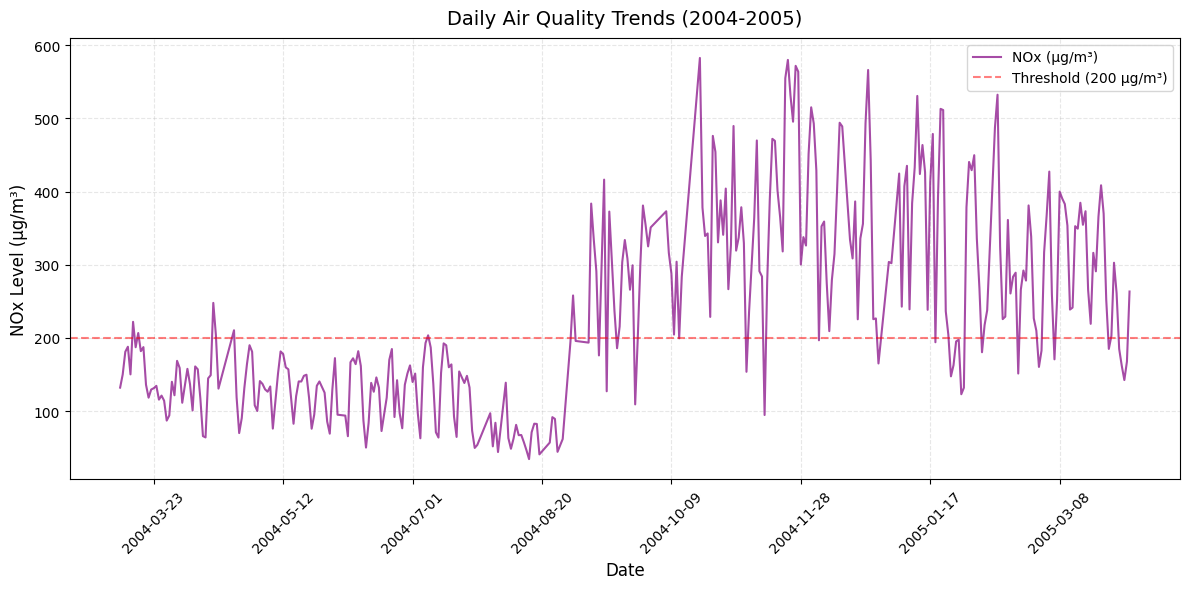

In [ ]:
# Visualize daily NOx trends
plt.figure(figsize=(12, 6))
plt.plot(daily_data["Date"], daily_data["NOx(GT)"], label="NOx (µg/m³)", color="purple", alpha=0.7)
plt.axhline(y=200, color="red", linestyle="--", label="Threshold (200 µg/m³)", alpha=0.5)
plt.title("Daily Air Quality Trends (2004-2005)", fontsize=14, pad=10)
plt.xlabel("Date", fontsize=12)
plt.ylabel("NOx Level (µg/m³)", fontsize=12)
plt.legend(loc="upper right", fontsize=10)
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.savefig("nox_trend_final.png")
plt.show()

# Comparison Visualization
**Purpose**
- To compare historical average NOx with real-time NOx levels.

**Functionality**
- Calculates the mean historical NOx and uses the current API NOx.
- Creates a bar chart and saves it as nox_comparison.png.
- Output: Displays the bar chart and saves it.

**Aims**
- Provide a visual comparison to contextualize real-time data.
- Enhance the presentation with an additional insight.

**Expected Output**
- A bar chart with two bars (historical avg vs. real-time NOx).

**Troubleshooting**
- ValueError - Ensure current_no2 is defined (from Block 3).

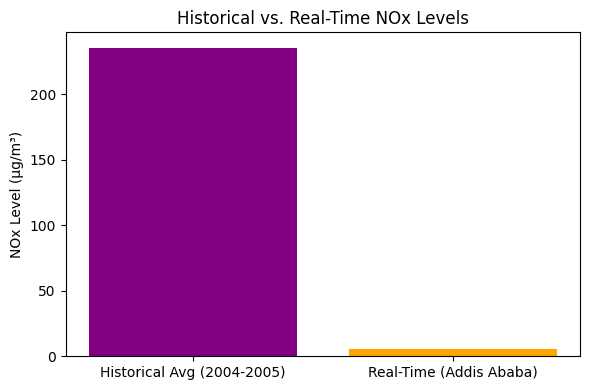

In [ ]:
# Compare historical vs. real-time NOx levels
historical_avg_no2 = daily_data["NOx(GT)"].mean()
real_time_no2 = current_no2

plt.figure(figsize=(6, 4))
plt.bar(["Historical Avg (2004-2005)", "Real-Time (Addis Ababa)"], [historical_avg_no2, real_time_no2], color=["purple", "orange"])
plt.title("Historical vs. Real-Time NOx Levels", fontsize=12)
plt.ylabel("NOx Level (µg/m³)", fontsize=10)
plt.tight_layout()
plt.savefig("nox_comparison.png")
plt.show()